<a href="https://colab.research.google.com/github/BioML-UGent/Advanced-AI-for-Bioinformatics/blob/main/04_RNNs/PClab_4_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNNs

## Introduction

Recurrent networks strictly operate on 1-D sequences. They can be used for a variety of tasks, pictured below:

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width = 500>

Examples of the settings in the picture:
- one to one: vanilla MLPs that map a fixed size 1-D vector to a 1-D vector for classification or regression
- one to many: Image captioning, given an input embedding (obtained with a CNN), a textual caption of variable length is generated.
- many to one: (1) Sentence classification such as sentiment analysis or (2) image generation from text: in both cases variable input texts are given as input and a fixed dimensional output is generated.
- many to many: (1) machine translation of a variable-length sentence to another variable-length sentence or (2) transcription of a variable-length .mp3 audio to a variable length text.
- many to many (1to1 correspondence): (1) Video classification: one label for a variable number of frames in the video (the video frame embedding can be obtained with a CNN and then input into a RNN), (2) autoregressive language modeling: trying to predict the next word in the sentence, for generative purposes or (3) word classification: classify every word as belonging to a category.

Note that these settings are not exclusive to recurrent neural networks. In fact, any network type that works on variable input sequences can be used towards these ends. Most famously of which are of course, Transformers, which have all but replaced RNNs in NLP and many other fields. Other than RNNs and Transformers, convolutional networks can also be used on variable length inputs: a 1D kernel can equally well convolve over a sequence of length $100$ as $1000$. It is only because of the linear layers at the end for classification requiring a specific number of input nodes that typical CNNs become applicable on only one specific input size.

# Part 1 - Time sequence prediction

## LSTM
Long Short-Term Memory (LSTM) networks are a special type of Recurrent Neural Network (RNN) designed to address the vanishing gradient problem, which makes it difficult for traditional RNNs to learn long-term dependencies in sequential data.

## Long Short-Term Memory (LSTM) Networks using PyTorch
LSTMs are widely used for sequence modeling tasks because of their ability to capture long-term dependencies. PyTorch provides a clean and flexible API to build and train LSTM models. In PyTorch, the nn.LSTM module handles the recurrence logic, while the rest of the architecture (such as fully connected layers, dropout, etc.) can be customized as needed.

Key Components
1. Input Size: Number of features in the input sequence at each time step.

2. Hidden Size: Number of features in the hidden state.

3. Number of Layers: Stacking multiple LSTM layers deepens the model.

4. Batch First: If set to True, input/output tensors are provided as (batch, seq_len, features) instead of (seq_len, batch, features).

5. Outputs:

Output Sequence: Hidden states at each time step.
Hidden State: Final hidden state for all layers.
Cell State: Final memory cell state for all layers.

## Step 1: Import Libraries and Prepare Data

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

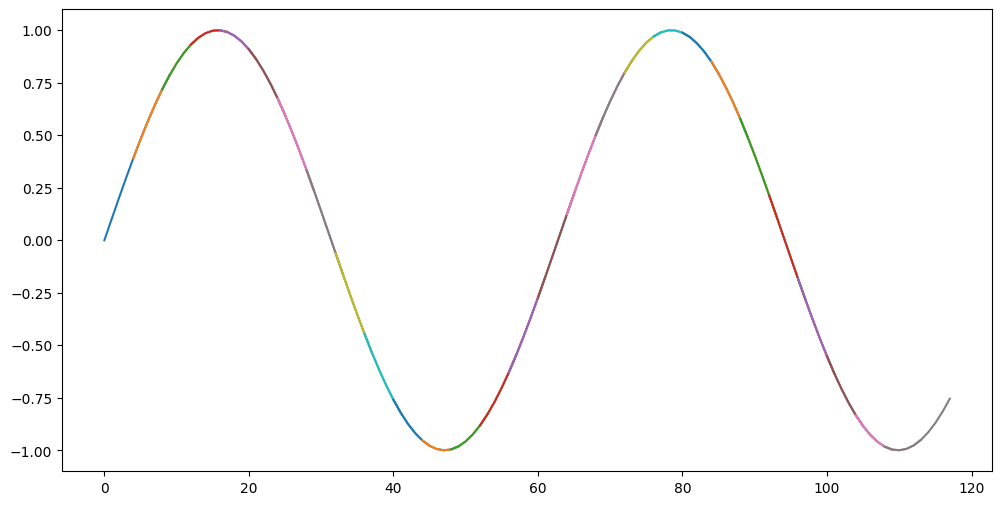

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

number_of_samples = 1000

t = np.linspace(0, 100, number_of_samples)

data = np.sin(t)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)\

seq_length = 10


train_data = data[:int(len(data)/2)]

X, y = create_sequences(train_data, seq_length)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)

test_data = data[int(len(data)/2):]

new_X, new_y = create_sequences(test_data, seq_length)
testX = torch.tensor(new_X[:, :, None], dtype=torch.float32)
testY = torch.tensor(new_y[:, None], dtype=torch.float32)


plt.figure(figsize=(12, 6))
for i in range(0, 110, 4):
  plt.plot(range(i, seq_length+i), X[i], label='Original Data')

## Step 2: Define the LSTM Model

### Exercise 1
 Define an LSTM model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(
                0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take last time step
        return out, hn, cn

## Step 3: Initialize Model

### Exercise 2
Initialize your model, as well as , loss Function, and optimizer

In [ ]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Step 4: Train the LSTM Model

### Exercise 3
Write a script to train your LSTM.

In [ ]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0, c0 = h0.detach(), c0.detach()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.7003
Epoch [20/100], Loss: 0.4929
Epoch [30/100], Loss: 0.4604
Epoch [40/100], Loss: 0.4413
Epoch [50/100], Loss: 0.4388
Epoch [60/100], Loss: 0.4368
Epoch [70/100], Loss: 0.4337
Epoch [80/100], Loss: 0.4305
Epoch [90/100], Loss: 0.4276
Epoch [100/100], Loss: 0.4257


### Step 5: Evaluate and Plot Predictions

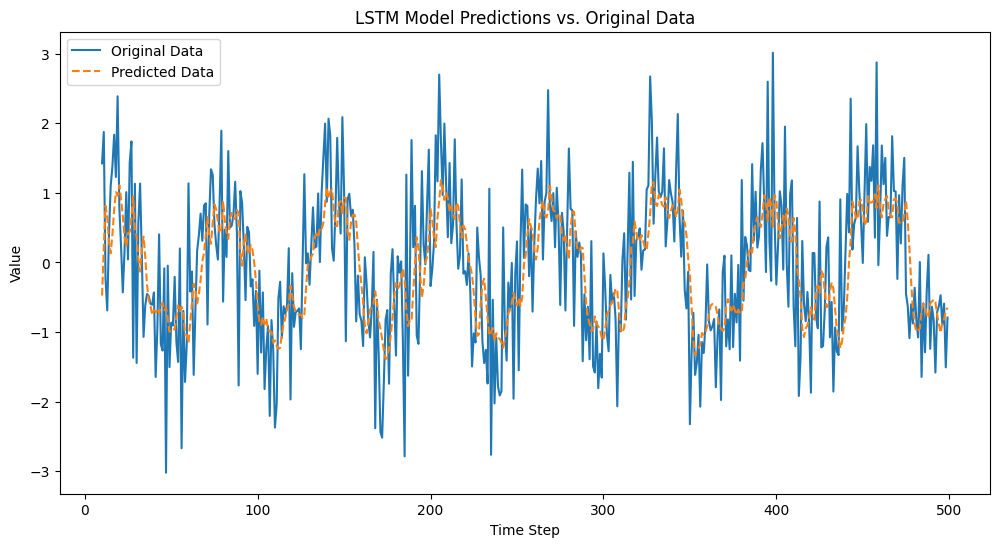

In [ ]:
model.eval()
predicted, _, _ = model(testX, h0, c0)

original = test_data[seq_length:]
time_steps = np.arange(seq_length, len(train_data))

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(),
         label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

### Step 6: Noisy data

Now, we'll add uncorrelated Gaussian noise (with variance equal to $\epsilon$) to the train and test samples, and train our model again.

### Exercise 4
Generate noisy dataset with $\epsilon = 0.1$.

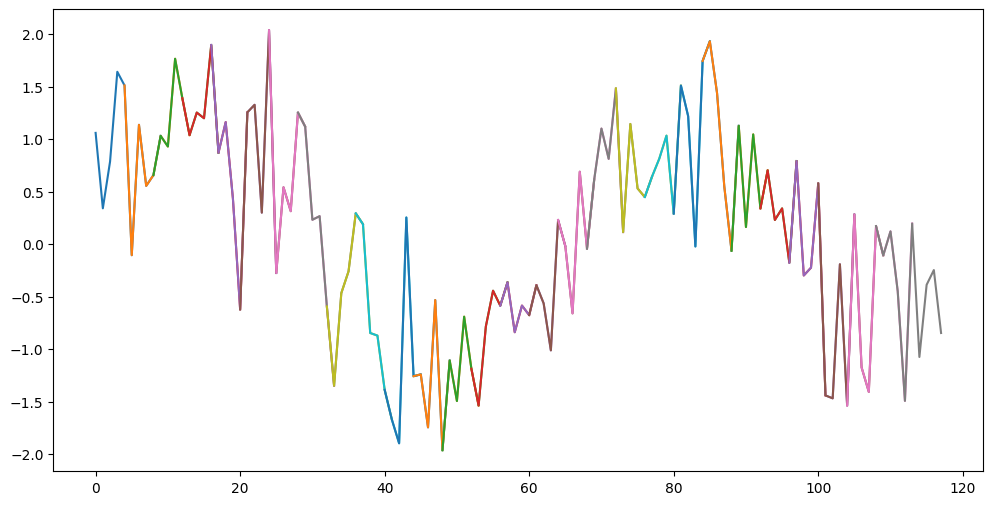

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

num_of_samples = 1000

t = np.linspace(0, 100, num_of_samples)

data = np.sin(t)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)\

seq_length = 10



eps_train = 0.6
noise_train = eps_train*np.random.randn(int(num_of_samples/2))
train_data = data[:int(len(data)/2)] + noise_train

X, y = create_sequences(train_data, seq_length)
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)


eps_test = 0.8
noise_test = eps_test*np.random.randn(int(num_of_samples/2))
test_data = data[int(len(data)/2):] + noise_test

new_X, new_y = create_sequences(test_data, seq_length)
testX = torch.tensor(new_X[:, :, None], dtype=torch.float32)
testY = torch.tensor(new_y[:, None], dtype=torch.float32)


plt.figure(figsize=(12, 6))
for i in range(0, 110, 4):
  plt.plot(range(i, seq_length+i), X[i], label='Original Data')

### Exercise 5
Re-train the model and look at the results. Try with a greater $\epsilon$ and discuss the results.

## Part 2: Bicycle traffic prediction


In this part, we will explore autoregressive modeling on bicycle traffic prediction using measurements from at Campus Coupure.

<img src="https://images0.persgroep.net/rcs/4cQwm-ofvb3eyIKMWnNf5axxLHg/diocontent/217261403/_fitwidth/694/?appId=21791a8992982cd8da851550a453bd7f&quality=0.8" width = 500>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/13_rnns/train_data.csv", "./train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/BioML-UGent/MLLS/main/13_rnns/test_data.csv", "./test_data.csv")

train_data = pd.read_csv("train_data.csv", sep = ",")
test_data = pd.read_csv("test_data.csv", sep = ",")

train_data

,Date_hour,Totaal
0,2023-01-01T00,111.0
1,2023-01-01T01,201.0
2,2023-01-01T02,170.0
3,2023-01-01T03,144.0
4,2023-01-01T04,155.0
...,...,...
4338,2023-06-30T19,465.0
4339,2023-06-30T20,325.0
4340,2023-06-30T21,260.0
4341,2023-06-30T22,239.0


Let's encode the Hour as separate feature

In [ ]:
train_data["Hour"] = train_data["Date_hour"].str.split("T", expand = True)[1].astype(float)
test_data["Hour"] = test_data["Date_hour"].str.split("T", expand = True)[1].astype(float)
train_data.head()

,Date_hour,Totaal,Hour
0,2023-01-01T00,111.0,0.0
1,2023-01-01T01,201.0,1.0
2,2023-01-01T02,170.0,2.0
3,2023-01-01T03,144.0,3.0
4,2023-01-01T04,155.0,4.0




Let's take a sequence length of 48 as a default, meaning that our samples will always coincide with two consecutive days.

In [ ]:
def generate_batches(sequence, seqlen = 48):
    batches = []
    for i in np.arange(0, len(sequence) - seqlen, seqlen):
        batches.append(sequence[i:i+seqlen])
    return torch.stack(batches)

train_batches = generate_batches(torch.tensor(train_data[["Hour", "Totaal"]].values.astype(np.float32)))

Let's see how a sample looks like:

In [ ]:
train_batches.shape

torch.Size([90, 48, 2])

In [ ]:
train_batches[0]

tensor([[  0., 111.],
        [  1., 201.],
        [  2., 170.],
        [  3., 144.],
        [  4., 155.],
        [  5., 140.],
        [  6., 109.],
        [  7.,  75.],
        [  8.,  43.],
        [  9.,  42.],
        [ 10.,  50.],
        [ 11.,  76.],
        [ 12.,  94.],
        [ 13., 113.],
        [ 14., 125.],
        [ 15., 173.],
        [ 16., 109.],
        [ 17., 100.],
        [ 18., 116.],
        [ 19.,  67.],
        [ 20., 120.],
        [ 21.,  82.],
        [ 22.,  60.],
        [ 23.,  29.],
        [  0.,  11.],
        [  1.,  10.],
        [  2.,   2.],
        [  3.,   5.],
        [  4.,  15.],
        [  5.,  33.],
        [  6.,  58.],
        [  7., 169.],
        [  8., 257.],
        [  9., 198.],
        [ 10., 129.],
        [ 11., 123.],
        [ 12., 206.],
        [ 13., 200.],
        [ 14., 192.],
        [ 15., 208.],
        [ 16., 266.],
        [ 17., 363.],
        [ 18., 299.],
        [ 19., 177.],
        [ 20.,  74.],
        [ 

We could give our input to the model like this, as the hour is a numerical value which can be interpreted using linear layers. It would make more sense to treat the hour variable as categorical and encode it using dummy variables (one-hot encoding).

In [ ]:
one_hot_hour = torch.nn.functional.one_hot(train_batches[:, :, 0].long())

one_hot_hour.shape

torch.Size([90, 48, 24])

In [ ]:
train_batches = torch.cat([train_batches[:, :, [1]], one_hot_hour], axis = 2)

In [ ]:
train_batches.shape

torch.Size([90, 48, 25])

In [ ]:
train_batches[0]

tensor([[111.,   1.,   0.,  ...,   0.,   0.,   0.],
        [201.,   0.,   1.,  ...,   0.,   0.,   0.],
        [170.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  8.,   0.,   0.,  ...,   1.,   0.,   0.],
        [  7.,   0.,   0.,  ...,   0.,   1.,   0.],
        [ 21.,   0.,   0.,  ...,   0.,   0.,   1.]])

Let's min-max scale the outputs. Remember: if you don't do this, your loss function (e.g. MSELoss) will be of a very big scale, affecting learning (i.e. you will need lower learning rates).
Hence, scaling allows us to make a better guess as to what a good learning rate will be.

In [ ]:
max_cyclists_train = train_batches[:, :, 0].max()
train_batches[:, :, 0] = train_batches[:, :, 0] / max_cyclists_train
train_batches[0]

tensor([[0.0583, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1056, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0893, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0042, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0037, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0110, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

Finally, let's prepare some batches in a similar way for the test set:

In [ ]:
test_batches = generate_batches(torch.tensor(test_data[["Hour", "Totaal"]].values.astype(np.float32)))
one_hot_hour = torch.nn.functional.one_hot(test_batches[:, :, 0].long())
test_batches = torch.cat([test_batches[:, :, [1]], one_hot_hour], axis = 2)
test_batches[:, :, 0] = test_batches[:, :, 0] / max_cyclists_train
test_batches[0]

tensor([[0.0788, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0483, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0257, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0904, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0788, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0504, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

### LSTMs in PyTorch

We will again use the LSTM, you can refer to the first part of this exercise for a recap on LSTMs.




### Exercise 6
Implement an LSTM model for cycler forecasting by completing the code below. Keep in mind how many input variables we have in our dataset. (Look at the $batches$ variable)

In [ ]:
class CyclerForecaster(nn.Module):
    def __init__(self, input_dim = 25, hidden_dim = 64):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, batch_first = True)
        self.output_head = nn.Linear(hidden_dim, 1)

    def forward(self, x):

        output, _ = self.lstm(x)

        return self.output_head(output)

In [ ]:
model = CyclerForecaster()

x = torch.randn(2, 48, 25)

y = model(x)

y.shape

torch.Size([2, 48, 1])

To create an input and an output, we have to do the above-mentioned shifting. In practice, this means that we take all but the last timepoints to create X, and all but the first timepoints to create Y, hence creating shifted X,y pairs.

Additionally, for y, we only want to keep the first variable, meaning the number of cyclists itself.

In [ ]:
X_train = train_batches[:, :-1]

y_train = train_batches[:, 1:]
y_train = y_train[:, :, [0]]

print(X_train.shape, y_train.shape)

torch.Size([90, 47, 25]) torch.Size([90, 47, 1])


Doing the same for the test data, and putting the things into datasets and dataloaders.

In [ ]:
X_test = test_batches[:, :-1]
y_test = test_batches[:, 1:, [0]]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True)

Note that we are just taking the first 80% of the data as training and the last 20% as validation set. Normally, we shuffle our data so that we are not biased. In this case, however, we can make a case for doing it our way: because the samples are ordered by day and month, the last samples will be from the summer months, where we may expect different patterns (June: exams, July: vacations).

### Exercise 7
Implement the training loop for the Cycler Forecaster using the same principles from last PC labs. You will need to increase the number of epochs as our dataset is quite small and each epoch only constitutes a small number of training steps.



In [ ]:
N_EPOCHS = 250

model = CyclerForecaster()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # SGD = stochastic gradient descent

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)

    predictions = []
    true_labels = []
    losses = []

    with torch.no_grad():
        model.eval()
        for batch in test_dataloader:
            X_batch, y_batch = batch

            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, y_batch)

            losses.append(loss.item())
            predictions.append(y_hat_batch)
            true_labels.append(y_batch)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)

    print(i, '\t', train_loss, np.mean(losses))

1 	 0.03943705791607499 0.009121604496613145
2 	 0.025017628058170278 0.01015693973749876
3 	 0.0241933756818374 0.008185326820239425
4 	 0.020316111001496513 0.005695240572094917
5 	 0.018634178054829437 0.005309477681294084
6 	 0.016754096606746316 0.004889632808044553
7 	 0.015760656058167417 0.004426004830747843
8 	 0.014571527329583963 0.004634823650121689
9 	 0.014102412465338906 0.004558157874271274
10 	 0.013478139182552695 0.004343041800893843
11 	 0.01216720863400648 0.004428879823535681
12 	 0.011497223594536385 0.003931033657863736
13 	 0.010859871554809311 0.0051866506692022085
14 	 0.010786435877283415 0.00432779616676271
15 	 0.009885445004329085 0.004451841930858791
16 	 0.009604178369045258 0.004746859660372138
17 	 0.009349492960609496 0.005412359605543315
18 	 0.008891786215826869 0.004872939549386501
19 	 0.008894799781652788 0.004832032602280378
20 	 0.0086763499227042 0.005104670999571681
21 	 0.008638608230588337 0.005222704727202654
22 	 0.008338144902760783 0.0

To evaluate our model beyond looking at a loss function going down: we can look at the autoregressive results for a random test sample:

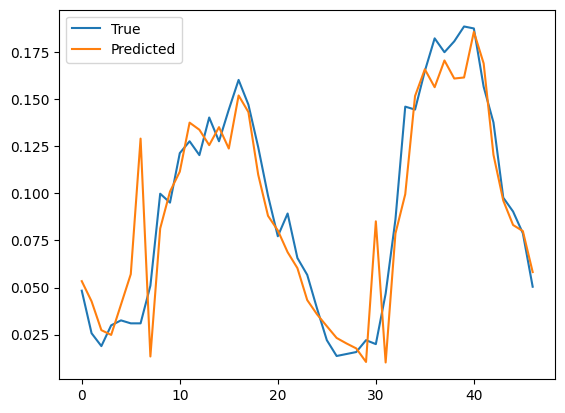

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(y_test[0])), y_test[0])
plt.plot(np.arange(len(y_test[0])), model(X_test[[0]]).detach().squeeze(0).numpy())
plt.legend(["True", "Predicted"])
plt.show()



So far, at every timestep, we are predicting only one timestep (hour) in advance. To do forecasting for a longer time limit, we should feed the predictions of the model back into the model, like this:


To perform this, we will create a helper function that extracts the next step:

In [ ]:
def generate_next_timestep(previous, model):
    with torch.no_grad():
        output = model(previous.unsqueeze(0))[0, -1]

    return output

def generate_n_timesteps(previous, model, n = 3):
    for _ in range(n):
        prediction = generate_next_timestep(previous, model)
        # to make a next prediction, we not only need to add the prediction but also the covariates (hour) to our next input:
        next_timestep_hour = nn.functional.one_hot((previous[-1, 1:].argmax() + 1) % 24, num_classes = 24)
        new_input = torch.cat([prediction, next_timestep_hour])
        previous = torch.cat([previous, new_input.unsqueeze(0)])

    return previous[:, 0]

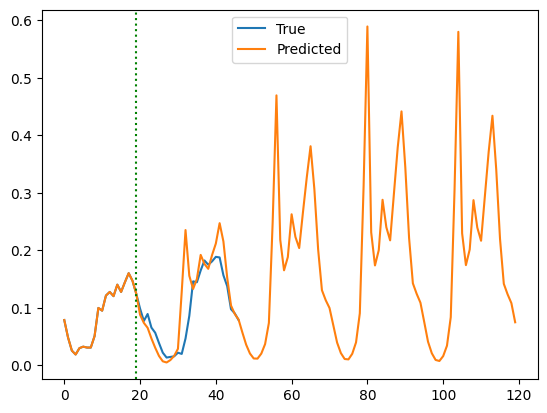

In [ ]:
sample_index = 0
priming_points = 20
generate_steps = 100


plt.plot(np.arange(len(X_test[sample_index])), X_test[sample_index, :, 0])
predictions = generate_n_timesteps(X_test[sample_index, :priming_points], model, n = generate_steps).numpy()
plt.plot(np.arange(len(predictions)), predictions)
plt.axvline(x = priming_points-1, color = "green", linestyle = ":")
plt.legend(["True", "Predicted"])
plt.show()